# 导入函数库

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds # 这个是指Tensorflow Datasets
import matplotlib.pyplot as plt

# 如果出现显存不够的错误,把这个代码加上

In [2]:
# 加入下面这个代码片段主要是因为TF2.0对RTX20系列显卡支持不是很好,容易爆显存,所以设置成用多少占多少显存,而不是一次性全占了(默认)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 定义网络结构

## 一些参数设置

In [3]:
layers = tf.keras.layers
models = tf.keras.models

## 定义InceptionV3模型用于caltech101物体分类

In [4]:
def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    bn_axis = 3
    x = layers.Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = layers.BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = layers.Activation('relu', name=name)(x)
    return x

In [5]:
def InceptionV3(input_shape=(224, 224, 3)): 
    img_input = layers.Input(shape=input_shape)

    channel_axis = 3

    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0: (None, 25, 25, 256)
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed0')

    # mixed 1: (None, 25, 25, 288)
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed1')

    # mixed 2: (None, 25, 25, 288)
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed2')

    # mixed 3: (None, 12, 12, 768)
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(
        branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed3')

    # mixed 4: (None, 12, 12, 768)
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed4')

    # mixed 5, 6: (None, 12, 12, 768)
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = layers.AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(5 + i))

    # mixed 7: (None, 12, 12, 768)
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed7')

    # mixed 8: (None, 5, 5, 1280)
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(
        branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch7x7x3, branch_pool],
        axis=channel_axis,
        name='mixed8')

    # mixed 9: (None, 5, 5, 2048)
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2],
            axis=channel_axis,
            name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

        branch_pool = layers.AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(9 + i))
        
    inputs = img_input  # 输入节点
    outputs = x # 输出节点
    # Create model.
    model = models.Model(inputs, outputs, name='inception_v3') # 模型需要设置输入和输出节点

    return model

In [6]:
pre_trained_model = InceptionV3()

In [7]:
x = layers.GlobalAveragePooling2D()(pre_trained_model.output)
x = layers.Dense(512, activation='relu', name='fc1')(x)
x = layers.Dense(102, activation='softmax', name='predictions')(x)

In [8]:
model = models.Model(pre_trained_model.input, x)
# Load weights.
weights_path = './models/inceptionv3.h5'
model.load_weights(weights_path)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## 模型训练日志记录

In [10]:
log_dir = './logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## 进行数据增强

In [11]:
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.resize_with_crop_or_pad(image, 256, 256)
    image = tf.image.random_crop(image, size=[224, 224, 3]) # Random crop back to 224x224
    return image, label

def augment(image, label):
    image, label = convert(image, label)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3) # Random brightness
    return image, label

## 数据读取并预处理

In [12]:
# 此处使用tfds的方式构建data pipeline
(raw_test, raw_train), metadata = tfds.load(
    'caltech101', # 数据集名称，这个是caltech101分类数据集，共102个类别(包含background类别)
    split=['test', 'train'], # 这里的raw_test和split的'test'对应，raw_train和split的'train'对应
    with_info=True, # 这个参数和metadata对应
    as_supervised=True, # 这个参数的作用是返回tuple形式的(input, label),举个例子，raw_test=tuple(input, label)
    data_dir='./tensorflow_datasets'
)

BATCH_SIZE = 4
SHUFFLE_BUFFER_SIZE = 3060 # 原始train_num=3060，把整个数据集加载进内存进行shuffle，效果更好

# 可以体验下这里是否加prefetch(tf.data.experimental.AUTOTUNE)和cache()的区别，对训练速度，以及CPU负载有影响
train_batches = raw_train.shuffle(SHUFFLE_BUFFER_SIZE).map(augment).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = raw_test.map(convert).batch(BATCH_SIZE)

## 进行模型训练

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.fit(
    train_batches,
    epochs=10,
    callbacks=[tensorboard_callback]
)

Epoch 1/10
765/765 [==============================] - 31s 40ms/step - loss: 3.8238 - accuracy: 0.8229
Epoch 2/10
765/765 [==============================] - 31s 40ms/step - loss: 3.8235 - accuracy: 0.8219
Epoch 3/10
765/765 [==============================] - 31s 40ms/step - loss: 3.8228 - accuracy: 0.8216
Epoch 4/10
765/765 [==============================] - 31s 41ms/step - loss: 3.8225 - accuracy: 0.8216
Epoch 5/10
765/765 [==============================] - 30s 39ms/step - loss: 3.8265 - accuracy: 0.8190
Epoch 6/10
765/765 [==============================] - 30s 40ms/step - loss: 3.8224 - accuracy: 0.8235
Epoch 7/10
765/765 [==============================] - 30s 39ms/step - loss: 3.8196 - accuracy: 0.8261
Epoch 8/10
765/765 [==============================] - 30s 39ms/step - loss: 3.8218 - accuracy: 0.8222
Epoch 9/10
765/765 [==============================] - 30s 39ms/step - loss: 3.8243 - accuracy: 0.8196
Epoch 10/10
765/765 [==============================] - 30s 40ms/step - loss: 3.819

## 模型训练后预测展示

garfield
camera
motorbikes
leopards
pizza


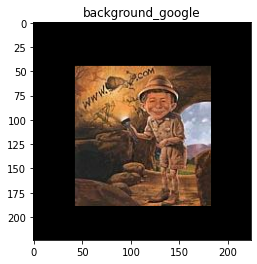

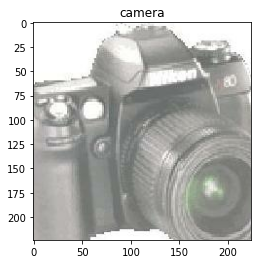

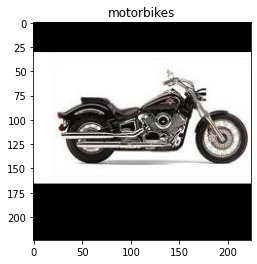

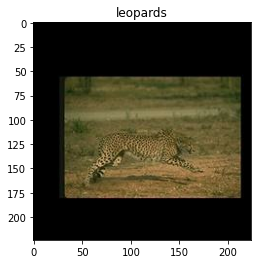

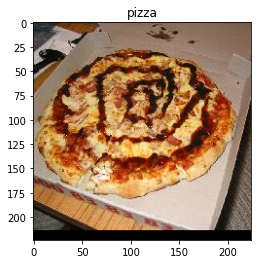

In [14]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_test.take(5):
    image, label = convert(image, label)
    predict = np.argmax(model.predict(np.expand_dims(image, axis=0)))
    print(get_label_name(predict))
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

## Baseline的test acc，并保存模型

In [15]:
_, baseline_model_accuracy = model.evaluate(test_batches, verbose=1)
print('Baseline test accuracy: ', baseline_model_accuracy)

keras_file = './test.h5'
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to: ', keras_file)

1521/1521 [==============================] - 20s 13ms/step - loss: 3.8579 - accuracy: 0.7888
Baseline test accuracy:  0.7887902855873108
Saved baseline model to:  ./test.h5
